<a href="https://colab.research.google.com/github/manypeople-AI/-/blob/main/miniproject_lgbm_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders

     |████████████████████████████████| 81kB 3.4MB/s 


In [2]:
import pandas as pd
import numpy as np
from itertools import product
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
import category_encoders as ce
import warnings

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Preparing & Preprocessing Dataset

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
cd /content/gdrive/My Drive/mini_project

/content/gdrive/My Drive/mini_project


In [5]:
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")
categ = pd.read_csv("item_categories.csv")
train = pd.read_csv("sales_train.csv")
test= pd.read_csv("test.csv").set_index('ID')

train data 결측치/이상치/중복행 제거

In [6]:
#train data 결측치 확인

train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

-> 결측치는 없음

In [7]:
#train/test data 중복 여부 확인
sum(train.duplicated()), sum(test.duplicated())

(6, 0)

-> train data에 중복행이 6개 존재

In [8]:
#item, category, shops 중복 여부 확인
sum(items.duplicated()),sum(categ.duplicated()),sum(shops.duplicated())

(0, 0, 0)

In [9]:
#train data 중복행 제거해주기
train.drop_duplicates(inplace=True)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935843 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 156.8+ MB


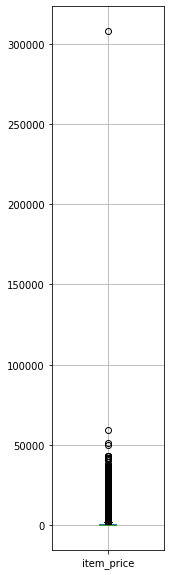

In [11]:
#이상치 처리
import seaborn as sns
import matplotlib.pyplot as plt

#상자그림으로 확인해보기 - item price
plt.figure(figsize=(2,10))
train.boxplot(column =['item_price'])
plt.show()

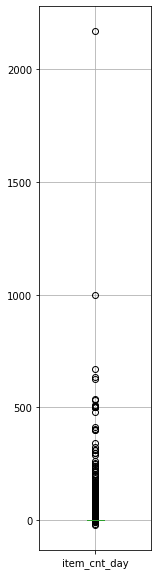

In [12]:
#상자그림 -  item_cnt_day(하루에 해당 item이 팔린 갯수)
plt.figure(figsize=(2,10))
train.boxplot(column=['item_cnt_day'])
plt.show()

In [13]:
#이상치 제거
train = train[train.item_price<=100000]
train = train[train.item_cnt_day<=1002]
train = train[train.item_price>=0]
train = train[train.item_cnt_day>=0]

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928484 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 156.4+ MB


category data

In [15]:
categ.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [16]:
pd.DataFrame(categ.item_category_name.values.reshape(-1,4))

,0,1,2,3
0,PC - Гарнитуры/Наушники,Аксессуары - PS2,Аксессуары - PS3,Аксессуары - PS4
1,Аксессуары - PSP,Аксессуары - PSVita,Аксессуары - XBOX 360,Аксессуары - XBOX ONE
2,Билеты (Цифра),Доставка товара,Игровые консоли - PS2,Игровые консоли - PS3
3,Игровые консоли - PS4,Игровые консоли - PSP,Игровые консоли - PSVita,Игровые консоли - XBOX 360
4,Игровые консоли - XBOX ONE,Игровые консоли - Прочие,Игры - PS2,Игры - PS3
5,Игры - PS4,Игры - PSP,Игры - PSVita,Игры - XBOX 360
6,Игры - XBOX ONE,Игры - Аксессуары для игр,Игры Android - Цифра,Игры MAC - Цифра
7,Игры PC - Дополнительные издания,Игры PC - Коллекционные издания,Игры PC - Стандартные издания,Игры PC - Цифра
8,"Карты оплаты (Кино, Музыка, Игры)",Карты оплаты - Live!,Карты оплаты - Live! (Цифра),Карты оплаты - PSN
9,Карты оплаты - Windows (Цифра),Кино - Blu-Ray,Кино - Blu-Ray 3D,Кино - Blu-Ray 4K


In [17]:
# 모든 카테고리 이름들에 기본과 하위 사이에 '-'가 있는 것은 X
# 문자가 아닌 것들의 바로 앞 이름을 추출해 그룹을 생성하고 그룹이름을 인코딩하는 레이블로 group_id 열을 생성


#pandas에서 문자열 관련 함수를 사용, 전처리하기 위해서는 명령어 앞에 str을 붙인다
#extract() : 원하는 문자열 추출, 정규표현식 이용
categ['group_name'] = categ['item_category_name'].str.extract(r'(^[\w\s]*)')

#strip() : 공백제거
categ['group_name'] = categ['group_name'].str.strip()

#label encoding 하기
categ['type_id']=le.fit_transform(categ.group_name.values)

categ.head(5)

,item_category_name,item_category_id,group_name,type_id
0,PC - Гарнитуры/Наушники,0,PC,0
1,Аксессуары - PS2,1,Аксессуары,1
2,Аксессуары - PS3,2,Аксессуары,1
3,Аксессуары - PS4,3,Аксессуары,1
4,Аксессуары - PSP,4,Аксессуары,1


In [19]:
categ=categ[['item_category_id','type_id']]
categ.head(3)

,item_category_id,type_id,subtype_id
0,0,0,29
1,1,1,9
2,2,1,10


item data

In [20]:
items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [21]:
#item_name clean

#소문자로 바꾸기
items['item_name'] = items['item_name'].str.lower()
items['item_name'] = items['item_name'].str.replace('.','')

#정규표현식, 제거?
for i in [r'[^\w\d\s\.]', r'\bthe\b', r'\bin\b', r'\bis\b',r'\bfor\b', r'\bof\b', r'\bon\b', r'\band\b',r'\bto\b', r'\bwith\b' , r'\byo\b']:
    items['item_name'] = items['item_name'].str.replace(i, ' ')


items['item_name'] = items['item_name'].str.replace(r'\b.\b', ' ')

In [22]:
#extract first n characters of name
items['item_name_no_space'] = items['item_name'].str.replace(' ', '')
items['item_name_first4'] = [x[:4] for x in items['item_name_no_space']]
items['item_name_first6'] = [x[:6] for x in items['item_name_no_space']]
items['item_name_first11'] = [x[:11] for x in items['item_name_no_space']]
del items['item_name_no_space']


In [23]:
#label encode 
items.item_name_first4 = le.fit_transform(items.item_name_first4.values)
items.item_name_first6 = le.fit_transform(items.item_name_first6.values)
items.item_name_first11 = le.fit_transform(items.item_name_first11.values)

In [24]:
#join category_name, group_name and group_id to items
items = items.join(categ.set_index('item_category_id'), on='item_category_id')
items.sample(10)

,item_name,item_id,item_category_id,item_name_first4,item_name_first6,item_name_first11,type_id,subtype_id
6115,renegade ops софтклаб pc цифровая версия,6115,31,944,1365,2512,8,61
11417,еще одна из рода болейн bd,11417,37,1970,2993,5146,10,1
8415,афера по американски,8415,40,1338,1988,3539,10,4
17606,периметр золотое издание steam версия pc ц...,17606,31,2857,4438,7777,8,61
3864,hello 1с мастер класс пример быстрой разраб...,3864,54,539,775,1387,11,61
16474,огарева регион,16474,40,2743,4256,7468,10,4
532,1с мир компьютера teachpro компьютерная график...,532,77,43,52,69,14,44
8255,амадей wb регион,8255,40,1285,1905,3400,10,4
4919,movavi game capture персональная pc цифровая...,4919,76,744,1074,1911,14,31
21012,футболка assassin creed syndicate rook,21012,61,3652,5656,9879,13,20


item data에서 중복행 제거

In [25]:
dupes = items[(items.duplicated(subset=['item_name','item_category_id'],keep=False))]
dupes

,item_name,item_id,item_category_id,item_name_first4,item_name_first6,item_name_first11,type_id,subtype_id
32,,32,40,0,0,0,10,4
126,1с аудиокниги сказки выпуск цифровая версия,126,44,33,38,52,11,22
127,1с аудиокниги сказки выпуск цифровая версия,127,44,33,38,52,11,22
128,1с аудиокниги сказки выпуск цифровая версия,128,44,33,38,52,11,22
129,1с аудиокниги сказки выпуск цифровая версия,129,44,33,38,52,11,22
...,...,...,...,...,...,...,...,...
22036,элвин бурундуки bd,22036,37,3832,5920,10302,10,1
22038,элвин бурундуки,22038,40,3832,5920,10302,10,4
22039,элвин бурундуки bd,22039,37,3832,5920,10302,10,1
22111,юмор сатира рассказы русских писателей ...,22111,43,3855,5947,10336,11,21


In [26]:
#isin() : series나 dataframe 안에 요소가 isin()메서드에 입력된 데이터에 있는지 판별해줌
dupes['in_test'] = dupes.item_id.isin(test.item_id.unique())
dupes = dupes.groupby('item_name').agg({'item_id':['first','last'],'in_test':['first','last']})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
#if both item id's are in the test set do nothing
dupes = dupes[(dupes[('in_test', 'first')]==False) | (dupes[('in_test', 'last')]==False)]
#if only the first id is in the test set assign this id to both
temp = dupes[dupes[('in_test', 'first')]==True]
keep_first = dict(zip(temp[('item_id', 'last')], temp[('item_id',  'first')]))
#if neither id or only the second id is in the test set, assign the second id to both
temp = dupes[dupes[('in_test', 'first')]==False]
keep_second = dict(zip(temp[('item_id', 'first')], temp[('item_id',  'last')]))
item_map = {**keep_first, **keep_second}

sales data

In [28]:
sales = (train
    .query('0 < item_price < 50000 and 0 < item_cnt_day < 1001') #removing outliers
    .replace({
        'shop_id':{0:57, 1:58, 11:10}, #replacing obsolete shop id's
        'item_id':item_map #fixing duplicate item id's  
    })    
)

#removing shops which don't appear in the test set
sales = sales[sales['shop_id'].isin(test.shop_id.unique())]

sales['date'] = pd.to_datetime(sales.date,format='%d.%m.%Y')
sales['weekday'] = sales.date.dt.dayofweek

#first day the item was sold, day 0 is the first day of the training set period
sales['first_sale_day'] = sales.date.dt.dayofyear 
sales['first_sale_day'] += 365 * (sales.date.dt.year-2013)
sales['first_sale_day'] = sales.groupby('item_id')['first_sale_day'].transform('min').astype('int16')

#revenue is needed to accurately calculate prices after grouping
sales['revenue'] = sales['item_cnt_day']*sales['item_price']

In [29]:
temp = sales.groupby(['shop_id','weekday']).agg({'item_cnt_day':'sum'}).reset_index()
temp = pd.merge(temp, sales.groupby(['shop_id']).agg({'item_cnt_day':'sum'}).reset_index(), on='shop_id', how='left')
temp.columns = ['shop_id','weekday', 'shop_day_sales', 'shop_total_sales']
temp['day_quality'] = temp['shop_day_sales']/temp['shop_total_sales']
temp = temp[['shop_id','weekday','day_quality']]

dates = pd.DataFrame(data={'date':pd.date_range(start='2013-01-01',end='2015-11-30')})
dates['weekday'] = dates.date.dt.dayofweek
dates['month'] = dates.date.dt.month
dates['year'] = dates.date.dt.year - 2013
dates['date_block_num'] = dates['year']*12 + dates['month'] - 1
dates['first_day_of_month'] = dates.date.dt.dayofyear
dates['first_day_of_month'] += 365 * dates['year']
dates = dates.join(temp.set_index('weekday'), on='weekday')
dates = dates.groupby(['date_block_num','shop_id','month','year']).agg({'day_quality':'sum','first_day_of_month':'min'}).reset_index()

dates.query('shop_id == 28').head(15)

,date_block_num,shop_id,month,year,day_quality,first_day_of_month
18,0,28,1,0,4.300037,1
60,1,28,2,0,4.000000,32
102,2,28,3,0,4.605952,60
144,3,28,4,0,4.193211,91
186,4,28,5,0,4.333970,121
228,5,28,6,0,4.472819,152
270,6,28,7,0,4.287644,182
312,7,28,8,0,4.492718,213
354,8,28,9,0,4.313648,244
396,9,28,10,0,4.300037,274


In [30]:
sales = (sales
     .groupby(['date_block_num', 'shop_id', 'item_id'])
     .agg({
         'item_cnt_day':'sum', 
         'revenue':'sum',
         'first_sale_day':'first'
     })
     .reset_index()
     .rename(columns={'item_cnt_day':'item_cnt'})
)
sales.sample(5)

,date_block_num,shop_id,item_id,item_cnt,revenue,first_sale_day
820630,19,16,16425,1.0,399.0,44
443941,9,55,21995,1.0,299.0,170
448374,9,58,16738,1.0,149.0,205
1140798,27,57,21669,3.0,447.0,705
485512,10,56,7064,1.0,199.0,2


constructing training dataframe

In [31]:
df = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]]))))

df = pd.DataFrame(np.vstack(df), columns=['shop_id', 'item_id', 'date_block_num'])
df.head()

,shop_id,item_id,date_block_num
0,2,27,0
1,2,33,0
2,2,317,0
3,2,438,0
4,2,473,0


In [32]:
test.columns

Index(['shop_id', 'item_id'], dtype='object')

In [33]:
#add the appropriate date_block_num value to the test set
test['date_block_num'] = 34

#append test set to training dataframe
df = pd.concat([df,test]).fillna(0)
df = df.reset_index()
del df['index']

In [34]:
items.head(3)

,item_name,item_id,item_category_id,item_name_first4,item_name_first6,item_name_first11,type_id,subtype_id
0,во власти наваждения пласт,0,40,1623,2463,4332,10,4
1,abbyy finereader 12 professional edition full...,1,76,105,130,211,14,31
2,лучах славы unv,2,40,2409,3707,6553,10,4


In [35]:
#join sales and item inforamtion to the training dataframe
df = pd.merge(df, sales, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)
df = pd.merge(df, dates, on=['date_block_num','shop_id'], how='left')
df = pd.merge(df, items.drop(columns=['item_name']), on='item_id', how='left')

adding shop information

In [36]:
df

,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,first_day_of_month,item_category_id,item_name_first4,item_name_first6,item_name_first11,type_id,subtype_id
0,2,27,0,1.0,2499.0,2.0,1,0,4.381749,1,19,1,1,1,5,10
1,2,33,0,1.0,499.0,2.0,1,0,4.381749,1,37,187,249,414,10,1
2,2,317,0,1.0,299.0,4.0,1,0,4.381749,1,45,33,38,52,11,23
3,2,438,0,1.0,299.0,19.0,1,0,4.381749,1,45,33,38,54,11,23
4,2,473,0,2.0,798.0,3.0,1,0,4.381749,1,49,35,43,59,11,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756434,45,18454,34,0.0,0.0,0.0,11,2,4.288065,1035,55,3230,5005,8681,12,2
8756435,45,16188,34,0.0,0.0,0.0,11,2,4.288065,1035,64,2622,4079,7191,13,42
8756436,45,15757,34,0.0,0.0,0.0,11,2,4.288065,1035,55,2693,4180,7335,12,2
8756437,45,19648,34,0.0,0.0,0.0,11,2,4.288065,1035,40,3465,5407,9365,10,4


In [37]:
#clustering shops
shops_cats = pd.DataFrame(
    np.array(list(product(*[df['shop_id'].unique(), df['item_category_id'].unique()]))),
    columns =['shop_id', 'item_category_id']
)
temp = df.groupby(['item_category_id', 'shop_id']).agg({'item_cnt':'sum'}).reset_index()
temp2 = temp.groupby('shop_id').agg({'item_cnt':'sum'}).rename(columns={'item_cnt':'shop_total'})
temp = temp.join(temp2, on='shop_id')
temp['category_proportion'] = temp['item_cnt']/temp['shop_total']
temp = temp[['shop_id', 'item_category_id', 'category_proportion']]
shops_cats = pd.merge(shops_cats, temp, on=['shop_id','item_category_id'], how='left')
shops_cats = shops_cats.fillna(0)

shops_cats = shops_cats.pivot(index='shop_id', columns=['item_category_id'])
kmeans = KMeans(n_clusters=7, random_state=0).fit(shops_cats)
shops_cats['shop_cluster'] = kmeans.labels_.astype('int8')

#adding these clusters to the shops dataframe
shops = shops.join(shops_cats['shop_cluster'], on='shop_id')

In [38]:
#removing unused shop ids
shops.dropna(inplace=True)

#cleaning the name column
shops['shop_name'] = shops['shop_name'].str.lower()
shops['shop_name'] = shops['shop_name'].str.replace(r'[^\w\d\s]', ' ')

#creating a column for the type of shop
shops['shop_type'] = 'regular'

#there is some overlap in tc and mall, mall is given precedence
shops.loc[shops['shop_name'].str.contains(r'tc'), 'shop_type'] = 'tc'
shops.loc[shops['shop_name'].str.contains(r'mall|center|mega'), 'shop_type'] = 'mall'
shops.loc[shops['shop_id'].isin([9,20]), 'shop_type'] = 'special'
shops.loc[shops['shop_id'].isin([12,55]), 'shop_type'] = 'online'

#the first word of shop name is largely sufficient as a city feature
shops['shop_city'] = shops['shop_name'].str.split().str[0]
shops.loc[shops['shop_id'].isin([12,55]), 'shop_city'] = 'online'
shops.shop_city = le.fit_transform(shops.shop_city.values)
shops.shop_type = le.fit_transform(shops.shop_type.values)
shops.head()

,shop_name,shop_id,shop_cluster,shop_type,shop_city
2,адыгея тц мега,2,4.0,1,1
3,балашиха трк октябрь киномир,3,0.0,1,2
4,волжский тц волга молл,4,0.0,1,3
5,вологда трц мармелад,5,0.0,1,4
6,воронеж плехановская 13,6,0.0,1,5


In [39]:
df = pd.merge(df, shops.drop(columns='shop_name'), on='shop_id', how='left')
df.head()

,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,first_day_of_month,item_category_id,item_name_first4,item_name_first6,item_name_first11,type_id,subtype_id,shop_cluster,shop_type,shop_city
0,2,27,0,1.0,2499.0,2.0,1,0,4.381749,1,19,1,1,1,5,10,4.0,1,1
1,2,33,0,1.0,499.0,2.0,1,0,4.381749,1,37,187,249,414,10,1,4.0,1,1
2,2,317,0,1.0,299.0,4.0,1,0,4.381749,1,45,33,38,52,11,23,4.0,1,1
3,2,438,0,1.0,299.0,19.0,1,0,4.381749,1,45,33,38,54,11,23,4.0,1,1
4,2,473,0,2.0,798.0,3.0,1,0,4.381749,1,49,35,43,59,11,39,4.0,1,1


Ages & Aggregating sales/price information

In [40]:
df['first_sale_day'] = df.groupby('item_id')['first_sale_day'].transform('max').astype('int16')
df.loc[df['first_sale_day']==0, 'first_sale_day'] = 1035
df['prev_days_on_sale'] = [max(idx) for idx in zip(df['first_day_of_month']-df['first_sale_day'],[0]*len(df))]
del df['first_day_of_month']

In [41]:
df['item_cnt_unclipped'] = df['item_cnt']
df['item_cnt'] = df['item_cnt'].clip(0, 20)

In [42]:
def downcast(df):
    #reduce size of the dataframe
    float_cols = [c for c in df if df[c].dtype in ["float64"]]
    int_cols = [c for c in df if df[c].dtype in ['int64']]
    df[float_cols] = df[float_cols].astype('float32')
    df[int_cols] = df[int_cols].astype('int16')
    return df
df = downcast(df)

In [43]:
df['item_age'] = (df['date_block_num'] - df.groupby('item_id')['date_block_num'].transform('min')).astype('int8')
df['item_name_first4_age'] = (df['date_block_num'] - df.groupby('item_name_first4')['date_block_num'].transform('min')).astype('int8')
df['item_name_first6_age'] = (df['date_block_num'] - df.groupby('item_name_first6')['date_block_num'].transform('min')).astype('int8')
df['item_name_first11_age'] = (df['date_block_num'] - df.groupby('item_name_first11')['date_block_num'].transform('min')).astype('int8')
df['category_age'] = (df['date_block_num'] - df.groupby('item_category_id')['date_block_num'].transform('min')).astype('int8')
df['group_age'] = (df['date_block_num'] - df.groupby('type_id')['date_block_num'].transform('min')).astype('int8')
df['shop_age'] = (df['date_block_num'] - df.groupby('shop_id')['date_block_num'].transform('min')).astype('int8')

In [44]:
#indicates whether shops have previously sold the item
temp = df.query('item_cnt > 0').groupby(['item_id','shop_id']).agg({'date_block_num':'min'}).reset_index()
temp.columns = ['item_id', 'shop_id', 'item_shop_first_sale']
df = pd.merge(df, temp, on=['item_id','shop_id'], how='left')
df['item_shop_first_sale'] = df['item_shop_first_sale'].fillna(50)
#item age that stays at 0 if a shop hasn't sold the item
df['item_age_if_shop_sale'] = (df['date_block_num'] > df['item_shop_first_sale']) * df['item_age']
#the length of time an item has been for sale without being sold at individual shops
df['item_age_without_shop_sale'] = (df['date_block_num'] <= df['item_shop_first_sale']) * df['item_age']
del df['item_shop_first_sale']

In [45]:
def agg_cnt_col(df, merging_cols, new_col,aggregation):
    temp = df.groupby(merging_cols).agg(aggregation).reset_index()
    temp.columns = merging_cols + [new_col]
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

#individual items across all shops
df = agg_cnt_col(df, ['date_block_num','item_id'],'item_cnt_all_shops',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','item_category_id','shop_id'],'item_cnt_all_shops_median',{'item_cnt':'median'}) 
#all items in category at individual shops
df = agg_cnt_col(df, ['date_block_num','item_category_id','shop_id'],'category_cnt',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','item_category_id','shop_id'],'category_cnt_median',{'item_cnt':'median'}) 
#all items in category across all shops
df = agg_cnt_col(df, ['date_block_num','item_category_id'],'category_cnt_all_shops',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','item_category_id'],'category_cnt_all_shops_median',{'item_cnt':'median'})
#all items in group
df = agg_cnt_col(df, ['date_block_num','type_id','shop_id'],'group_cnt',{'item_cnt':'mean'})
#all items in group across all shops
df = agg_cnt_col(df, ['date_block_num','type_id'],'group_cnt_all_shops',{'item_cnt':'mean'})
#all items at individual shops
df = agg_cnt_col(df, ['date_block_num','shop_id'],'shop_cnt',{'item_cnt':'mean'})
#all items at all shops within the city
df = agg_cnt_col(df, ['date_block_num','shop_city'],'city_cnt',{'item_cnt':'mean'})

In [46]:
def new_item_sales(df, merging_cols, new_col):
    temp = (
        df
        .query('item_age==0')
        .groupby(merging_cols)['item_cnt']
        .mean()
        .reset_index()
        .rename(columns={'item_cnt': new_col})
    )
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

#mean units sold of new item in category at individual shop
df = new_item_sales(df, ['date_block_num','item_category_id','shop_id'], 'new_items_in_cat')
#mean units sold of new item in category across all shops
df = new_item_sales(df, ['date_block_num','item_category_id'], 'new_items_in_cat_all_shops')

In [47]:
def agg_price_col(df, merging_cols, new_col):
    temp = df.groupby(merging_cols).agg({'revenue':'sum','item_cnt_unclipped':'sum'}).reset_index()
    temp[new_col] = temp['revenue']/temp['item_cnt_unclipped']
    temp = temp[merging_cols + [new_col]]
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

#average item price
df = agg_price_col(df,['date_block_num','item_id'],'item_price')
#average price of items in category
df = agg_price_col(df,['date_block_num','item_category_id'],'category_price')
#average price of all items
df = agg_price_col(df,['date_block_num'],'block_price')

In [48]:
df = downcast(df)

Lagging values & features that use prior information

In [49]:
def lag_feature(df, lag, col, merge_cols):        
    temp = df[merge_cols + [col]]
    temp = temp.groupby(merge_cols).agg({f'{col}':'first'}).reset_index()
    temp.columns = merge_cols + [f'{col}_lag{lag}']
    temp['date_block_num'] += lag
    df = pd.merge(df, temp, on=merge_cols, how='left')
    df[f'{col}_lag{lag}'] = df[f'{col}_lag{lag}'].fillna(0).astype('float32')
    return df

In [50]:
lag12_cols = {
    'item_cnt':['date_block_num', 'shop_id', 'item_id'],
    'item_cnt_all_shops':['date_block_num', 'item_id'],
    'category_cnt':['date_block_num', 'shop_id', 'item_category_id'],
    'category_cnt_all_shops':['date_block_num', 'item_category_id'],
    'group_cnt':['date_block_num', 'shop_id', 'type_id'],
    'group_cnt_all_shops':['date_block_num', 'type_id'],
    'shop_cnt':['date_block_num', 'shop_id'],
    'city_cnt':['date_block_num', 'shop_city'],
    'new_items_in_cat':['date_block_num', 'shop_id', 'item_category_id'],
    'new_items_in_cat_all_shops':['date_block_num', 'item_category_id']
}
for col,merge_cols in lag12_cols.items():
    df[f'{col}_lag1to12'] = 0
    for i in range(1,13):
        df = lag_feature(df, i, col, merge_cols)
        df[f'{col}_lag1to12'] += df[f'{col}_lag{i}']
        if i > 2:
            del df[f'{col}_lag{i}']
    if col == 'item_cnt':
        del df[f'{col}_lag1']
        del df[f'{col}_lag2']        
    else:
        del df[col]

In [51]:
lag2_cols = {
    'item_cnt_unclipped':['date_block_num', 'shop_id', 'item_id'],
    'item_cnt_all_shops_median':['date_block_num', 'item_id'],
    'category_cnt_median':['date_block_num', 'shop_id', 'category_id'],
    'category_cnt_all_shops_median':['date_block_num', 'category_id']
}
for col in lag2_cols:
    df = lag_feature(df, 1, col, merge_cols)
    df = lag_feature(df, 2, col, merge_cols)
    if col!='item_cnt_unclipped':
        del df[col]

In [52]:
df['item_cnt_diff'] = df['item_cnt_unclipped_lag1']/df['item_cnt_lag1to12']
df['item_cnt_all_shops_diff'] = df['item_cnt_all_shops_lag1']/df['item_cnt_all_shops_lag1to12']
df['category_cnt_diff'] = df['category_cnt_lag1']/df['category_cnt_lag1to12']
df['category_cnt_all_shops_diff'] = df['category_cnt_all_shops_lag1']/df['category_cnt_all_shops_lag1to12']

In [53]:
df = lag_feature(df, 1, 'category_price',['date_block_num', 'item_category_id'])
df = lag_feature(df, 1, 'block_price',['date_block_num'])
del df['category_price'], df['block_price']

In [54]:
df.loc[(df['item_age']>0) & (df['item_cnt_lag1to12'].isna()), 'item_cnt_lag1to12'] = 0
df.loc[(df['category_age']>0) & (df['category_cnt_lag1to12'].isna()), 'category_cnt_lag1to12'] = 0
df.loc[(df['group_age']>0) & (df['group_cnt_lag1to12'].isna()), 'group_cnt_lag1to12'] = 0

In [55]:
df['item_cnt_lag1to12'] /= [min(idx) for idx in zip(df['item_age'],df['shop_age'],[12]*len(df))]
df['item_cnt_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['item_age'],[12]*len(df))]
df['category_cnt_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],df['shop_age'],[12]*len(df))]
df['category_cnt_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],[12]*len(df))]
df['group_cnt_lag1to12'] /= [min(idx) for idx in zip(df['group_age'],df['shop_age'],[12]*len(df))]
df['group_cnt_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['group_age'],[12]*len(df))]
df['city_cnt_lag1to12'] /= [min(idx) for idx in zip(df['date_block_num'],[12]*len(df))]
df['shop_cnt_lag1to12'] /= [min(idx) for idx in zip(df['shop_age'],[12]*len(df))]
df['new_items_in_cat_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],df['shop_age'],[12]*len(df))]
df['new_items_in_cat_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],[12]*len(df))]

In [56]:
df = downcast(df)

In [57]:
def past_information(df, merging_cols, new_col, aggregation):
    temp = []
    for i in range(1,35):
        block = df.query(f'date_block_num < {i}').groupby(merging_cols).agg(aggregation).reset_index()
        block.columns = merging_cols + [new_col]
        block['date_block_num'] = i
        block = block[block[new_col]>0]
        temp.append(block)
    temp = pd.concat(temp)
    df = pd.merge(df, temp, on=['date_block_num']+merging_cols, how='left')
    return df

#average item price in latest block item was sold
df = past_information(df, ['item_id'],'last_item_price',{'item_price':'last'})
#total units of item sold at individual shop
df = past_information(df, ['shop_id','item_id'],'item_cnt_sum_alltime',{'item_cnt':'sum'})
#total units of item sold at all shops
df = past_information(df, ['item_id'],'item_cnt_sum_alltime_allshops',{'item_cnt':'sum'})

#these columns are no longer needed, and would cause data leakage if retained
del df['revenue'], df['item_cnt_unclipped'], df['item_price']

In [58]:
df['relative_price_item_block_lag1'] = df['last_item_price']/df['block_price_lag1']

In [59]:
df['item_cnt_per_day_alltime'] = (df['item_cnt_sum_alltime']/df['prev_days_on_sale']).fillna(0)
df['item_cnt_per_day_alltime_allshops'] = (df['item_cnt_sum_alltime_allshops']/df['prev_days_on_sale']).fillna(0)

In [60]:
import gc
gc.collect()
df = downcast(df)

In [61]:
def matching_name_cat_age(df,n,all_shops):
    temp_cols = [f'same_name{n}catage_cnt','date_block_num', f'item_name_first{n}','item_age','item_category_id']
    if all_shops:
        temp_cols[0] += '_all_shops'
    else:
        temp_cols += ['shop_id']
    temp = []
    for i in range(1,35):
        block = (
            df
            .query(f'date_block_num < {i}')
            .groupby(temp_cols[2:])
            .agg({'item_cnt':'mean'})
            .reset_index()
            .rename(columns={'item_cnt':temp_cols[0]})
        )
        block = block[block[temp_cols[0]]>0]
        block['date_block_num'] = i
        temp.append(block)
    temp = pd.concat(temp)
    df = pd.merge(df, temp, on=temp_cols[1:], how='left')
    return df

for n in [4,6,11]:
    for all_shops in [True,False]:
        df = matching_name_cat_age(df,n,all_shops)

In [62]:
#assign appropriate datatypes
df = downcast(df)
int8_cols = [
    'item_cnt','month','type_id','shop_type',
    'shop_city','shop_id','date_block_num','item_category_id',
    'item_age',
]
int16_cols = [
    'item_id','item_name_first4',
    'item_name_first6','item_name_first11'
]
for col in int8_cols:
    df[col] = df[col].astype('int8')
for col in int16_cols:
    df[col] = df[col].astype('int16')

In [63]:
def nearby_item_data(df,col):
    if col in ['item_cnt_unclipped_lag1','item_cnt_lag1to12']:
        cols = ['date_block_num', 'shop_id', 'item_id']
        temp = df[cols + [col]] 
    else:
        cols = ['date_block_num', 'item_id']
        temp = df.groupby(cols).agg({col:'first'}).reset_index()[cols + [col]]   
    
    temp.columns = cols + [f'below_{col}']
    temp['item_id'] += 1
    df = pd.merge(df, temp, on=cols, how='left')
    
    temp.columns = cols + [f'above_{col}']
    temp['item_id'] -= 2
    df = pd.merge(df, temp, on=cols, how='left')
    
    return df

item_cols = ['item_cnt_unclipped_lag1','item_cnt_lag1to12',
             'item_cnt_all_shops_lag1','item_cnt_all_shops_lag1to12']
for col in item_cols:
    df = nearby_item_data(df,col)
    
del temp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


encoding name information

In [68]:
results = Counter()
items['item_name'].str.split().apply(results.update)

words = []
cnts = []
for key, value in results.items():
    words.append(key)
    cnts.append(value)
    
counts = pd.DataFrame({'word':words,'count':cnts})
common_words = counts.query('count>200').word.to_list()
for word in common_words:
    items[f'{word}_in_name'] = items['item_name'].str.contains(word).astype('int8')
drop_cols = [
    'item_id','item_category_id','item_name','item_name_first4',
    'item_name_first6','item_name_first11',
    'type_id'
]
items = items.drop(columns=drop_cols)

KeyError: ignored

In [67]:
df = df.join(items, on='item_id')

ValueError: ignored

In [69]:
def binary_encode(df, letters, cols):
    encoder = ce.BinaryEncoder(cols=[f'item_name_first{letters}'], return_df=True)
    temp = encoder.fit_transform(df[f'item_name_first{letters}'])
    df = pd.concat([df,temp], axis=1)
    del df[f'item_name_first{letters}_0']
    name_cols = [f'item_name_first{letters}_{x}' for x in range(1,cols)]
    df[name_cols] = df[name_cols].astype('int8')
    return df

df = binary_encode(df, 11, 15)
    
del df['item_name_first4'], df['item_name_first6']

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [70]:
#save dataframe for later use
df.to_pickle('df_complete.pkl')
#Reset the kernel to clear memory.
%reset -f

# Modeling

In [72]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go

pd.set_option('display.max_rows', 160)
pd.set_option('display.max_columns', 160)
pd.set_option('display.max_colwidth', 30)

import warnings
warnings.filterwarnings("ignore")

In [74]:
#load the saved training dataframe
df = pd.read_pickle('df_complete.pkl')

X_train = df[~df.date_block_num.isin([0,1,33,34])]
y_train = X_train['item_cnt']
del X_train['item_cnt']

X_val = df[df['date_block_num']==33]
y_val = X_val['item_cnt']
del X_val['item_cnt']

X_test = df[df['date_block_num']==34].drop(columns='item_cnt')
X_test = X_test.reset_index()
del X_test['index']

#free memory
del df

In [75]:
!pip install optuna

     |████████████████████████████████| 296kB 4.3MB/s 
     |████████████████████████████████| 163kB 6.9MB/s 
     |████████████████████████████████| 81kB 4.5MB/s 
     |████████████████████████████████| 81kB 5.3MB/s 
     |████████████████████████████████| 112kB 8.9MB/s 
     |████████████████████████████████| 143kB 8.8MB/s 
     |████████████████████████████████| 51kB 4.4MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=98938e12ed0abfbb6ab369aa71a3a228695c6c9b2626f5f81603f59eb9dcbb22
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [76]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [79]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval  = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [82]:
def objective(trial):

    # choose parameters that you want
    
    param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    model = lgb.train(param, 
                      lgb_train,
                      valid_sets=[lgb_train,lgb_eval],
                      early_stopping_rounds=15, #10,
                      verbose_eval=1)
    
    y_pred = model.predict(X_val)
    accuracy = mean_squared_error(y_val, y_pred,squared=False)

    return accuracy

In [83]:
from sklearn.metrics import mean_squared_error

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-03-09 16:41:23,989] A new study created in memory with name: no-name-564e77ec-ea37-468c-8487-105dd7383b42


[1]	training's rmse: 1.19286	valid_1's rmse: 1.03593
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.14637	valid_1's rmse: 0.993853
[3]	training's rmse: 1.10538	valid_1's rmse: 0.958665
[4]	training's rmse: 1.0692	valid_1's rmse: 0.929476
[5]	training's rmse: 1.03823	valid_1's rmse: 0.908206
[6]	training's rmse: 1.01099	valid_1's rmse: 0.887478
[7]	training's rmse: 0.988149	valid_1's rmse: 0.870312
[8]	training's rmse: 0.967909	valid_1's rmse: 0.856556
[9]	training's rmse: 0.951323	valid_1's rmse: 0.844838
[10]	training's rmse: 0.935431	valid_1's rmse: 0.834243
[11]	training's rmse: 0.922528	valid_1's rmse: 0.826139
[12]	training's rmse: 0.911679	valid_1's rmse: 0.818446
[13]	training's rmse: 0.901224	valid_1's rmse: 0.813728
[14]	training's rmse: 0.892873	valid_1's rmse: 0.807825
[15]	training's rmse: 0.884518	valid_1's rmse: 0.802778
[16]	training's rmse: 0.877161	valid_1's rmse: 0.797519
[17]	training's rmse: 0.870697	valid_1's rmse: 0.794721
[18

[I 2021-03-09 16:42:01,652] Trial 0 finished with value: 0.7673692625949375 and parameters: {'lambda_l1': 1.4934242562472903e-06, 'lambda_l2': 6.965338907769272, 'num_leaves': 100, 'feature_fraction': 0.6834922879209142, 'bagging_fraction': 0.4174423970202388, 'bagging_freq': 4, 'min_child_samples': 31}. Best is trial 0 with value: 0.7673692625949375.


[1]	training's rmse: 1.1912	valid_1's rmse: 1.03431
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.14334	valid_1's rmse: 0.992752
[3]	training's rmse: 1.10163	valid_1's rmse: 0.957204
[4]	training's rmse: 1.06651	valid_1's rmse: 0.928851
[5]	training's rmse: 1.03496	valid_1's rmse: 0.906022
[6]	training's rmse: 1.00769	valid_1's rmse: 0.884406
[7]	training's rmse: 0.984264	valid_1's rmse: 0.868168
[8]	training's rmse: 0.963864	valid_1's rmse: 0.853376
[9]	training's rmse: 0.946299	valid_1's rmse: 0.841612
[10]	training's rmse: 0.931296	valid_1's rmse: 0.832751
[11]	training's rmse: 0.9176	valid_1's rmse: 0.822673
[12]	training's rmse: 0.906662	valid_1's rmse: 0.816445
[13]	training's rmse: 0.895888	valid_1's rmse: 0.807533
[14]	training's rmse: 0.887236	valid_1's rmse: 0.801812
[15]	training's rmse: 0.878921	valid_1's rmse: 0.798009
[16]	training's rmse: 0.871618	valid_1's rmse: 0.793081
[17]	training's rmse: 0.865046	valid_1's rmse: 0.789617
[18]	

[I 2021-03-09 16:42:57,228] Trial 1 finished with value: 0.7693497243581668 and parameters: {'lambda_l1': 0.00010883453132494786, 'lambda_l2': 2.373541968084358e-05, 'num_leaves': 107, 'feature_fraction': 0.7764767022832233, 'bagging_fraction': 0.42338971237059597, 'bagging_freq': 3, 'min_child_samples': 69}. Best is trial 0 with value: 0.7673692625949375.


[1]	training's rmse: 1.18559	valid_1's rmse: 1.03519
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.13333	valid_1's rmse: 0.993009
[3]	training's rmse: 1.08735	valid_1's rmse: 0.953432
[4]	training's rmse: 1.04726	valid_1's rmse: 0.923099
[5]	training's rmse: 1.01264	valid_1's rmse: 0.898891
[6]	training's rmse: 0.98287	valid_1's rmse: 0.876882
[7]	training's rmse: 0.956671	valid_1's rmse: 0.860638
[8]	training's rmse: 0.933817	valid_1's rmse: 0.844903
[9]	training's rmse: 0.91448	valid_1's rmse: 0.832451
[10]	training's rmse: 0.896955	valid_1's rmse: 0.821203
[11]	training's rmse: 0.882009	valid_1's rmse: 0.812615
[12]	training's rmse: 0.86895	valid_1's rmse: 0.805215
[13]	training's rmse: 0.857437	valid_1's rmse: 0.799365
[14]	training's rmse: 0.847154	valid_1's rmse: 0.794129
[15]	training's rmse: 0.837686	valid_1's rmse: 0.787588
[16]	training's rmse: 0.829409	valid_1's rmse: 0.783405
[17]	training's rmse: 0.821935	valid_1's rmse: 0.780133
[18]

[I 2021-03-09 16:45:01,018] Trial 2 finished with value: 0.7601270340623884 and parameters: {'lambda_l1': 1.0172371307184663e-07, 'lambda_l2': 1.4910699816411428e-06, 'num_leaves': 253, 'feature_fraction': 0.9783922996897737, 'bagging_fraction': 0.8184042886893004, 'bagging_freq': 7, 'min_child_samples': 20}. Best is trial 2 with value: 0.7601270340623884.


[1]	training's rmse: 1.19046	valid_1's rmse: 1.03589
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.15252	valid_1's rmse: 1.0047
[3]	training's rmse: 1.11138	valid_1's rmse: 0.972748
[4]	training's rmse: 1.07559	valid_1's rmse: 0.945267
[5]	training's rmse: 1.04193	valid_1's rmse: 0.919004
[6]	training's rmse: 1.0155	valid_1's rmse: 0.89866
[7]	training's rmse: 0.989045	valid_1's rmse: 0.879088
[8]	training's rmse: 0.966928	valid_1's rmse: 0.862992
[9]	training's rmse: 0.947384	valid_1's rmse: 0.848802
[10]	training's rmse: 0.932505	valid_1's rmse: 0.838477
[11]	training's rmse: 0.918485	valid_1's rmse: 0.828935
[12]	training's rmse: 0.907452	valid_1's rmse: 0.821688
[13]	training's rmse: 0.895725	valid_1's rmse: 0.818441
[14]	training's rmse: 0.886904	valid_1's rmse: 0.813768
[15]	training's rmse: 0.87666	valid_1's rmse: 0.806225
[16]	training's rmse: 0.869061	valid_1's rmse: 0.802186
[17]	training's rmse: 0.860662	valid_1's rmse: 0.798734
[18]	tr

[I 2021-03-09 16:46:21,818] Trial 3 finished with value: 0.7668688798463942 and parameters: {'lambda_l1': 0.00140897034211525, 'lambda_l2': 2.8494512175942797, 'num_leaves': 157, 'feature_fraction': 0.4478317971782345, 'bagging_fraction': 0.9077260451589504, 'bagging_freq': 5, 'min_child_samples': 84}. Best is trial 2 with value: 0.7601270340623884.


[1]	training's rmse: 1.18664	valid_1's rmse: 1.0345
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.13513	valid_1's rmse: 0.991053
[3]	training's rmse: 1.08989	valid_1's rmse: 0.954045
[4]	training's rmse: 1.05014	valid_1's rmse: 0.922985
[5]	training's rmse: 1.01601	valid_1's rmse: 0.896928
[6]	training's rmse: 0.986768	valid_1's rmse: 0.87605
[7]	training's rmse: 0.960913	valid_1's rmse: 0.860673
[8]	training's rmse: 0.93824	valid_1's rmse: 0.845561
[9]	training's rmse: 0.919262	valid_1's rmse: 0.833317
[10]	training's rmse: 0.902375	valid_1's rmse: 0.820981
[11]	training's rmse: 0.887518	valid_1's rmse: 0.811273
[12]	training's rmse: 0.875108	valid_1's rmse: 0.80285
[13]	training's rmse: 0.863438	valid_1's rmse: 0.796652
[14]	training's rmse: 0.853471	valid_1's rmse: 0.792163
[15]	training's rmse: 0.844515	valid_1's rmse: 0.788106
[16]	training's rmse: 0.836642	valid_1's rmse: 0.78443
[17]	training's rmse: 0.82925	valid_1's rmse: 0.780484
[18]	tr

[I 2021-03-09 16:48:40,565] Trial 4 finished with value: 0.7618720813048295 and parameters: {'lambda_l1': 3.976201229071882e-07, 'lambda_l2': 1.4412580629649279e-06, 'num_leaves': 244, 'feature_fraction': 0.9528881214659496, 'bagging_fraction': 0.8105203187057941, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 2 with value: 0.7601270340623884.


[1]	training's rmse: 1.19054	valid_1's rmse: 1.03549
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.14199	valid_1's rmse: 0.994379
[3]	training's rmse: 1.09932	valid_1's rmse: 0.958218
[4]	training's rmse: 1.06213	valid_1's rmse: 0.928885
[5]	training's rmse: 1.02941	valid_1's rmse: 0.902016
[6]	training's rmse: 1.00056	valid_1's rmse: 0.881776
[7]	training's rmse: 0.976546	valid_1's rmse: 0.863568
[8]	training's rmse: 0.955379	valid_1's rmse: 0.849457
[9]	training's rmse: 0.936975	valid_1's rmse: 0.837265
[10]	training's rmse: 0.920635	valid_1's rmse: 0.825693
[11]	training's rmse: 0.906793	valid_1's rmse: 0.815829
[12]	training's rmse: 0.894962	valid_1's rmse: 0.808808
[13]	training's rmse: 0.883829	valid_1's rmse: 0.803514
[14]	training's rmse: 0.874981	valid_1's rmse: 0.79745
[15]	training's rmse: 0.86637	valid_1's rmse: 0.791721
[16]	training's rmse: 0.858308	valid_1's rmse: 0.788308
[17]	training's rmse: 0.851465	valid_1's rmse: 0.785085
[18]

[I 2021-03-09 16:49:27,306] Trial 5 finished with value: 0.7658181322138837 and parameters: {'lambda_l1': 3.3168393947810233, 'lambda_l2': 5.882813456898847, 'num_leaves': 166, 'feature_fraction': 0.6581297774761674, 'bagging_fraction': 0.4966305058024126, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 2 with value: 0.7601270340623884.


[1]	training's rmse: 1.18798	valid_1's rmse: 1.034
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.14701	valid_1's rmse: 1.00535
[3]	training's rmse: 1.10491	valid_1's rmse: 0.972429
[4]	training's rmse: 1.06777	valid_1's rmse: 0.942064
[5]	training's rmse: 1.03223	valid_1's rmse: 0.918096
[6]	training's rmse: 1.00171	valid_1's rmse: 0.895542
[7]	training's rmse: 0.974588	valid_1's rmse: 0.876734
[8]	training's rmse: 0.951378	valid_1's rmse: 0.860792
[9]	training's rmse: 0.931091	valid_1's rmse: 0.847762
[10]	training's rmse: 0.915122	valid_1's rmse: 0.838687
[11]	training's rmse: 0.899378	valid_1's rmse: 0.829693
[12]	training's rmse: 0.887508	valid_1's rmse: 0.823035
[13]	training's rmse: 0.875549	valid_1's rmse: 0.817555
[14]	training's rmse: 0.866044	valid_1's rmse: 0.811672
[15]	training's rmse: 0.855246	valid_1's rmse: 0.805985
[16]	training's rmse: 0.847017	valid_1's rmse: 0.800905
[17]	training's rmse: 0.838229	valid_1's rmse: 0.796303
[18]	

[I 2021-03-09 16:50:37,012] Trial 6 finished with value: 0.7701092075657466 and parameters: {'lambda_l1': 0.00011091904542351567, 'lambda_l2': 1.2191886761707696e-05, 'num_leaves': 234, 'feature_fraction': 0.48017979691016865, 'bagging_fraction': 0.8150580892654572, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 2 with value: 0.7601270340623884.


[1]	training's rmse: 1.18916	valid_1's rmse: 1.03518
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.14025	valid_1's rmse: 0.996381
[3]	training's rmse: 1.09734	valid_1's rmse: 0.959639
[4]	training's rmse: 1.05896	valid_1's rmse: 0.930571
[5]	training's rmse: 1.02516	valid_1's rmse: 0.901764
[6]	training's rmse: 0.995667	valid_1's rmse: 0.879712
[7]	training's rmse: 0.970423	valid_1's rmse: 0.858695
[8]	training's rmse: 0.949743	valid_1's rmse: 0.844785
[9]	training's rmse: 0.930929	valid_1's rmse: 0.831763
[10]	training's rmse: 0.913772	valid_1's rmse: 0.819378
[11]	training's rmse: 0.899081	valid_1's rmse: 0.809975
[12]	training's rmse: 0.887218	valid_1's rmse: 0.803913
[13]	training's rmse: 0.875395	valid_1's rmse: 0.79745
[14]	training's rmse: 0.866312	valid_1's rmse: 0.792943
[15]	training's rmse: 0.857305	valid_1's rmse: 0.788553
[16]	training's rmse: 0.849186	valid_1's rmse: 0.784207
[17]	training's rmse: 0.8418	valid_1's rmse: 0.780333
[18]

[I 2021-03-09 16:51:19,409] Trial 7 finished with value: 0.7603728184896887 and parameters: {'lambda_l1': 1.038884232521601e-05, 'lambda_l2': 7.013001325568332e-05, 'num_leaves': 177, 'feature_fraction': 0.6383411615169531, 'bagging_fraction': 0.44797807485213675, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 2 with value: 0.7601270340623884.


[1]	training's rmse: 1.18977	valid_1's rmse: 1.03497
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.14085	valid_1's rmse: 0.992897
[3]	training's rmse: 1.09708	valid_1's rmse: 0.956301
[4]	training's rmse: 1.05975	valid_1's rmse: 0.928693
[5]	training's rmse: 1.0275	valid_1's rmse: 0.905586
[6]	training's rmse: 0.99882	valid_1's rmse: 0.886359
[7]	training's rmse: 0.974397	valid_1's rmse: 0.867801
[8]	training's rmse: 0.953156	valid_1's rmse: 0.85239
[9]	training's rmse: 0.934978	valid_1's rmse: 0.840594
[10]	training's rmse: 0.918249	valid_1's rmse: 0.82959
[11]	training's rmse: 0.903996	valid_1's rmse: 0.821989
[12]	training's rmse: 0.892181	valid_1's rmse: 0.815233
[13]	training's rmse: 0.881733	valid_1's rmse: 0.809675
[14]	training's rmse: 0.873387	valid_1's rmse: 0.804682
[15]	training's rmse: 0.86458	valid_1's rmse: 0.801495
[16]	training's rmse: 0.856419	valid_1's rmse: 0.795877
[17]	training's rmse: 0.849007	valid_1's rmse: 0.792775
[18]	t

[I 2021-03-09 16:53:05,940] Trial 8 finished with value: 0.7660882190448881 and parameters: {'lambda_l1': 0.018399074468877136, 'lambda_l2': 0.024892193114694365, 'num_leaves': 160, 'feature_fraction': 0.6956432083978805, 'bagging_fraction': 0.9339439891573593, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 2 with value: 0.7601270340623884.


[1]	training's rmse: 1.18658	valid_1's rmse: 1.0327
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.13412	valid_1's rmse: 0.991375
[3]	training's rmse: 1.08882	valid_1's rmse: 0.955469
[4]	training's rmse: 1.05041	valid_1's rmse: 0.924417
[5]	training's rmse: 1.01628	valid_1's rmse: 0.899292
[6]	training's rmse: 0.986343	valid_1's rmse: 0.878279
[7]	training's rmse: 0.960574	valid_1's rmse: 0.85929
[8]	training's rmse: 0.938115	valid_1's rmse: 0.84367
[9]	training's rmse: 0.918581	valid_1's rmse: 0.832035
[10]	training's rmse: 0.901194	valid_1's rmse: 0.819849
[11]	training's rmse: 0.886697	valid_1's rmse: 0.810953
[12]	training's rmse: 0.874074	valid_1's rmse: 0.802965
[13]	training's rmse: 0.862512	valid_1's rmse: 0.797199
[14]	training's rmse: 0.852855	valid_1's rmse: 0.792113
[15]	training's rmse: 0.844183	valid_1's rmse: 0.789059
[16]	training's rmse: 0.836184	valid_1's rmse: 0.785609
[17]	training's rmse: 0.828745	valid_1's rmse: 0.781282
[18]

[I 2021-03-09 16:54:48,508] Trial 9 finished with value: 0.7619021931963327 and parameters: {'lambda_l1': 1.3597963829255162, 'lambda_l2': 4.1763261584303534e-05, 'num_leaves': 250, 'feature_fraction': 0.7851207528329275, 'bagging_fraction': 0.8474578772643777, 'bagging_freq': 5, 'min_child_samples': 72}. Best is trial 2 with value: 0.7601270340623884.


[1]	training's rmse: 1.21231	valid_1's rmse: 1.05497
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.1829	valid_1's rmse: 1.03126
[3]	training's rmse: 1.15729	valid_1's rmse: 1.0108
[4]	training's rmse: 1.13608	valid_1's rmse: 0.994514
[5]	training's rmse: 1.11715	valid_1's rmse: 0.978898
[6]	training's rmse: 1.10135	valid_1's rmse: 0.967661
[7]	training's rmse: 1.08741	valid_1's rmse: 0.95742
[8]	training's rmse: 1.07515	valid_1's rmse: 0.948732
[9]	training's rmse: 1.06488	valid_1's rmse: 0.941411
[10]	training's rmse: 1.05571	valid_1's rmse: 0.934566
[11]	training's rmse: 1.04744	valid_1's rmse: 0.928094
[12]	training's rmse: 1.03902	valid_1's rmse: 0.921545
[13]	training's rmse: 1.03232	valid_1's rmse: 0.917415
[14]	training's rmse: 1.02645	valid_1's rmse: 0.911133
[15]	training's rmse: 1.01999	valid_1's rmse: 0.906235
[16]	training's rmse: 1.01467	valid_1's rmse: 0.901197
[17]	training's rmse: 1.00936	valid_1's rmse: 0.897264
[18]	training's rm

[I 2021-03-09 16:55:45,520] Trial 10 finished with value: 0.8129956566995753 and parameters: {'lambda_l1': 1.0975437448945578e-08, 'lambda_l2': 8.69477860427203e-08, 'num_leaves': 4, 'feature_fraction': 0.9988370095551754, 'bagging_fraction': 0.6495708009019985, 'bagging_freq': 7, 'min_child_samples': 27}. Best is trial 2 with value: 0.7601270340623884.


[1]	training's rmse: 1.1887	valid_1's rmse: 1.03386
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.14903	valid_1's rmse: 1.00485
[3]	training's rmse: 1.10507	valid_1's rmse: 0.96901
[4]	training's rmse: 1.06622	valid_1's rmse: 0.93931
[5]	training's rmse: 1.03164	valid_1's rmse: 0.916302
[6]	training's rmse: 1.00071	valid_1's rmse: 0.894203
[7]	training's rmse: 0.97469	valid_1's rmse: 0.874591
[8]	training's rmse: 0.952362	valid_1's rmse: 0.859201
[9]	training's rmse: 0.93318	valid_1's rmse: 0.847984
[10]	training's rmse: 0.916922	valid_1's rmse: 0.836911
[11]	training's rmse: 0.902684	valid_1's rmse: 0.828584
[12]	training's rmse: 0.890814	valid_1's rmse: 0.820421
[13]	training's rmse: 0.877646	valid_1's rmse: 0.81374
[14]	training's rmse: 0.868424	valid_1's rmse: 0.809202
[15]	training's rmse: 0.8584	valid_1's rmse: 0.803951
[16]	training's rmse: 0.850202	valid_1's rmse: 0.80101
[17]	training's rmse: 0.842009	valid_1's rmse: 0.796774
[18]	trainin

[I 2021-03-09 16:56:55,363] Trial 11 finished with value: 0.7728876503973064 and parameters: {'lambda_l1': 5.7351353143726e-07, 'lambda_l2': 0.00200456414749916, 'num_leaves': 196, 'feature_fraction': 0.5489864406178542, 'bagging_fraction': 0.6349453558050466, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 2 with value: 0.7601270340623884.


[1]	training's rmse: 1.19426	valid_1's rmse: 1.03415
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.14824	valid_1's rmse: 0.995795
[3]	training's rmse: 1.10971	valid_1's rmse: 0.959962
[4]	training's rmse: 1.07572	valid_1's rmse: 0.932811
[5]	training's rmse: 1.0468	valid_1's rmse: 0.909452
[6]	training's rmse: 1.02143	valid_1's rmse: 0.888031
[7]	training's rmse: 1.00034	valid_1's rmse: 0.871715
[8]	training's rmse: 0.980805	valid_1's rmse: 0.856827
[9]	training's rmse: 0.964664	valid_1's rmse: 0.846092
[10]	training's rmse: 0.950984	valid_1's rmse: 0.835998
[11]	training's rmse: 0.938923	valid_1's rmse: 0.826535
[12]	training's rmse: 0.928847	valid_1's rmse: 0.819142
[13]	training's rmse: 0.918887	valid_1's rmse: 0.812896
[14]	training's rmse: 0.910381	valid_1's rmse: 0.807826
[15]	training's rmse: 0.90244	valid_1's rmse: 0.803074
[16]	training's rmse: 0.895434	valid_1's rmse: 0.801816
[17]	training's rmse: 0.888973	valid_1's rmse: 0.798911
[18]	

[I 2021-03-09 16:58:14,296] Trial 12 finished with value: 0.7705629370581881 and parameters: {'lambda_l1': 1.5030506335780406e-08, 'lambda_l2': 1.6545424597715244e-08, 'num_leaves': 58, 'feature_fraction': 0.8749765864156187, 'bagging_fraction': 0.7327947402192597, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 2 with value: 0.7601270340623884.


[1]	training's rmse: 1.18837	valid_1's rmse: 1.03583
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.14379	valid_1's rmse: 1.00478
[3]	training's rmse: 1.09955	valid_1's rmse: 0.967977
[4]	training's rmse: 1.06085	valid_1's rmse: 0.93723
[5]	training's rmse: 1.02601	valid_1's rmse: 0.911982
[6]	training's rmse: 0.995234	valid_1's rmse: 0.889312
[7]	training's rmse: 0.969511	valid_1's rmse: 0.870188
[8]	training's rmse: 0.947753	valid_1's rmse: 0.855087
[9]	training's rmse: 0.928244	valid_1's rmse: 0.839623
[10]	training's rmse: 0.912346	valid_1's rmse: 0.828321
[11]	training's rmse: 0.897906	valid_1's rmse: 0.819488
[12]	training's rmse: 0.88629	valid_1's rmse: 0.812119
[13]	training's rmse: 0.872697	valid_1's rmse: 0.806818
[14]	training's rmse: 0.863071	valid_1's rmse: 0.800577
[15]	training's rmse: 0.853302	valid_1's rmse: 0.795806
[16]	training's rmse: 0.845447	valid_1's rmse: 0.792666
[17]	training's rmse: 0.837181	valid_1's rmse: 0.788118
[18]

[I 2021-03-09 16:59:07,280] Trial 13 finished with value: 0.7628757452286417 and parameters: {'lambda_l1': 6.525348236362002e-06, 'lambda_l2': 2.7065809701039235e-07, 'num_leaves': 207, 'feature_fraction': 0.5782466976529681, 'bagging_fraction': 0.5819012480689143, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 2 with value: 0.7601270340623884.


[1]	training's rmse: 1.1883	valid_1's rmse: 1.03386
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.14406	valid_1's rmse: 0.996927
[3]	training's rmse: 1.0997	valid_1's rmse: 0.958965
[4]	training's rmse: 1.06091	valid_1's rmse: 0.930032
[5]	training's rmse: 1.02624	valid_1's rmse: 0.904173
[6]	training's rmse: 0.995267	valid_1's rmse: 0.882492
[7]	training's rmse: 0.969199	valid_1's rmse: 0.863989
[8]	training's rmse: 0.94796	valid_1's rmse: 0.847852
[9]	training's rmse: 0.928555	valid_1's rmse: 0.834151
[10]	training's rmse: 0.912238	valid_1's rmse: 0.821792
[11]	training's rmse: 0.897491	valid_1's rmse: 0.812934
[12]	training's rmse: 0.88583	valid_1's rmse: 0.806191
[13]	training's rmse: 0.872248	valid_1's rmse: 0.801758
[14]	training's rmse: 0.862896	valid_1's rmse: 0.796935
[15]	training's rmse: 0.853308	valid_1's rmse: 0.792715
[16]	training's rmse: 0.845534	valid_1's rmse: 0.789479
[17]	training's rmse: 0.837307	valid_1's rmse: 0.7864
[18]	tr

[I 2021-03-09 17:00:21,839] Trial 14 finished with value: 0.7625036932679955 and parameters: {'lambda_l1': 3.8979136874522685e-08, 'lambda_l2': 0.0011562690131924503, 'num_leaves': 205, 'feature_fraction': 0.5891930139709409, 'bagging_fraction': 0.9941848182302486, 'bagging_freq': 6, 'min_child_samples': 45}. Best is trial 2 with value: 0.7601270340623884.


Number of finished trials: 15
Best trial: {'lambda_l1': 1.0172371307184663e-07, 'lambda_l2': 1.4910699816411428e-06, 'num_leaves': 253, 'feature_fraction': 0.9783922996897737, 'bagging_fraction': 0.8184042886893004, 'bagging_freq': 7, 'min_child_samples': 20}


In [84]:
best_params = study.best_trial.params
print(f'Best trial parameters\n{best_params}')

Best trial parameters
{'lambda_l1': 1.0172371307184663e-07, 'lambda_l2': 1.4910699816411428e-06, 'num_leaves': 253, 'feature_fraction': 0.9783922996897737, 'bagging_fraction': 0.8184042886893004, 'bagging_freq': 7, 'min_child_samples': 20}


In [85]:
# add some fix params

x = {"objective": "regression",
     "metric"   : "rmse",
     "verbosity": -1,
     "boosting_type": "gbdt"}

best_params.update(x)
best_params

{'bagging_fraction': 0.8184042886893004,
 'bagging_freq': 7,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.9783922996897737,
 'lambda_l1': 1.0172371307184663e-07,
 'lambda_l2': 1.4910699816411428e-06,
 'metric': 'rmse',
 'min_child_samples': 20,
 'num_leaves': 253,
 'objective': 'regression',
 'verbosity': -1}

In [86]:
evals_result = {} 

model = lgb.train(best_params,
                  lgb_train,
                  valid_sets=[lgb_train,lgb_eval],

                  evals_result=evals_result,
                  early_stopping_rounds=10, # 20
                  verbose_eval=1,
                  )

[1]	training's rmse: 1.18559	valid_1's rmse: 1.03519
Training until validation scores don't improve for 10 rounds.
[2]	training's rmse: 1.13333	valid_1's rmse: 0.993009
[3]	training's rmse: 1.08735	valid_1's rmse: 0.953432
[4]	training's rmse: 1.04726	valid_1's rmse: 0.923099
[5]	training's rmse: 1.01264	valid_1's rmse: 0.898891
[6]	training's rmse: 0.98287	valid_1's rmse: 0.876882
[7]	training's rmse: 0.956671	valid_1's rmse: 0.860638
[8]	training's rmse: 0.933817	valid_1's rmse: 0.844903
[9]	training's rmse: 0.91448	valid_1's rmse: 0.832451
[10]	training's rmse: 0.896955	valid_1's rmse: 0.821203
[11]	training's rmse: 0.882009	valid_1's rmse: 0.812615
[12]	training's rmse: 0.86895	valid_1's rmse: 0.805215
[13]	training's rmse: 0.857437	valid_1's rmse: 0.799365
[14]	training's rmse: 0.847154	valid_1's rmse: 0.794129
[15]	training's rmse: 0.837686	valid_1's rmse: 0.787588
[16]	training's rmse: 0.829409	valid_1's rmse: 0.783405
[17]	training's rmse: 0.821935	valid_1's rmse: 0.780133
[18]

In [87]:
y_pred = model.predict(X_val)
mean_squared_error(y_val, y_pred,squared=False)

0.7601270340623884

Plot metrics recorded during training...


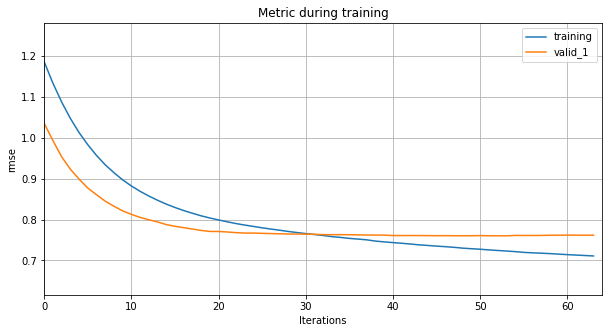

In [88]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, figsize=(10, 5))

In [91]:
test= pd.read_csv("test.csv").set_index('ID')

In [92]:
# predicting model

Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.head(10)

,ID,item_cnt_month
0,0,0.531757
1,1,1.513707
2,2,0.914372
3,3,0.798708
4,4,2.476738
5,5,0.477419
6,6,0.529161
7,7,0.183665
8,8,1.409973
9,9,0.476697


In [93]:
submission.to_csv('final submission.csv', index=False)